In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [12]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [14]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

**Lets  visualize the Data**

In [36]:
sentiment_counts

array([2878, 1363,  604])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


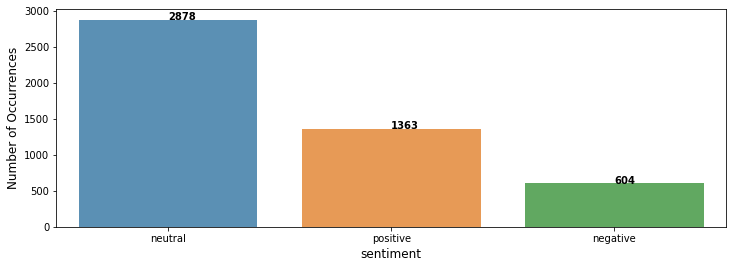

In [42]:
cnt_pro = df['sentiment'].value_counts()
sentiment_counts= cnt_pro.values
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
for i, v in enumerate(sentiment_counts):
    plt.text( i, v ,s= str(v), fontweight= 'heavy')
plt.show();

In [43]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [50]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


Now we convert text into lower case and remove punctuations

In [51]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
    
df['Message'] = df['Message'].apply(cleanText)

# Before Model building lets explore basic things about data!!

In [54]:
import nltk

from nltk import sent_tokenize
from nltk import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [81]:
text = df.Message
text = text.tolist()

In [95]:
sentences= []
words= []
for i in range(100):
  line = word_tokenize(text[i])
  for i in line:
    words.append(i)

print(len(words))

3091


In [96]:
from nltk.probability import FreqDist
fdist= FreqDist(words)

fdist.most_common(10)

[('the', 145),
 (',', 116),
 ('.', 99),
 ('of', 89),
 ('to', 86),
 ('in', 86),
 ('and', 60),
 ('eur', 48),
 ('from', 47),
 ('%', 47)]

In [98]:
#Lets remove some more symbols and puntuations
words_no_punc= []

for w in words:
  if w.isalpha():
    words_no_punc.append(w.lower())

print(words_no_punc)
print(len(words_no_punc))

['technopolis', 'plans', 'to', 'develop', 'in', 'stages', 'an', 'area', 'of', 'no', 'less', 'than', 'square', 'meters', 'in', 'order', 'to', 'host', 'companies', 'working', 'in', 'computer', 'technologies', 'and', 'telecommunications', 'the', 'statement', 'said', 'the', 'international', 'electronic', 'industry', 'company', 'elcoteq', 'has', 'laid', 'off', 'tens', 'of', 'employees', 'from', 'its', 'tallinn', 'facility', 'contrary', 'to', 'earlier', 'layoffs', 'the', 'company', 'contracted', 'the', 'ranks', 'of', 'its', 'office', 'workers', 'the', 'daily', 'postimees', 'reported', 'with', 'the', 'new', 'production', 'plant', 'the', 'company', 'would', 'increase', 'its', 'capacity', 'to', 'meet', 'the', 'epected', 'increase', 'in', 'demand', 'and', 'would', 'improve', 'the', 'use', 'of', 'raw', 'materials', 'and', 'therefore', 'increase', 'the', 'production', 'profitability', 'according', 'to', 'the', 'company', 'updated', 'strategy', 'for', 'the', 'years', 'basware', 'targets', 'a', 'net

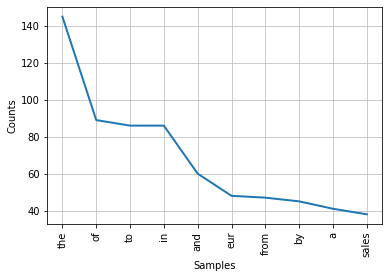

([('the', 145),
  ('of', 89),
  ('to', 86),
  ('in', 86),
  ('and', 60),
  ('eur', 48),
  ('from', 47),
  ('by', 45),
  ('a', 41),
  ('sales', 38)],
 None)

In [99]:
fdist= FreqDist(words_no_punc)
fdist.most_common(10), fdist.plot(10)

**Lets remove the stopwords and then see the most frequent words**

In [101]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [105]:
from nltk.corpus import stopwords

stopwords= stopwords.words('english')

clean_words= []

for w in words_no_punc:
  if w not in stopwords:
    clean_words.append(w)

print('Now we see the length of words has become: ', len(clean_words))

Now we see the length of words has become:  1488


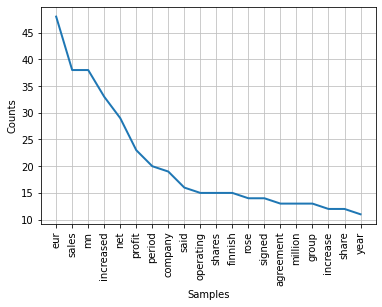

In [109]:
fdist= FreqDist(clean_words)

fdist.plot(20)

Lets make some word cloud

In [114]:
MyFile= open('Reviews.txt','w')

for element in text:
    MyFile.write(element)
    MyFile.write('\n')
MyFile.close()

In [115]:
text_file = open("Reviews.txt")

text = text_file.read()

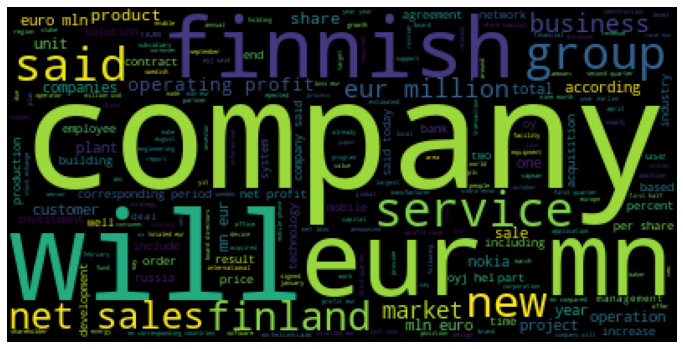

In [119]:
from wordcloud import WordCloud



wordcloud= WordCloud().generate(text)

plt.figure(figsize = (12, 12)) 
plt.imshow(wordcloud) 

plt.axis("off") 
plt.show()

Tokenization

In [123]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X ,maxlen= MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 4845 unique tokens.
Shape of data tensor: (4845, 50)


In [124]:
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', "''", 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

# Doc2Vec :)

In [125]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4844/4844 [00:00<00:00, 957455.64it/s]


In [126]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 1348905.10it/s]


CPU times: user 11.7 s, sys: 56.6 ms, total: 11.7 s
Wall time: 11.9 s


In [127]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [128]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
          embedding_matrix[i]=vec

Measuring the most Similar Vectors

In [129]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.9090215563774109),
 ('profits', 0.845723569393158),
 ('68.3', 0.8238663673400879),
 ('income', 0.8060348033905029),
 ('ns1v', 0.7569140195846558),
 ('1.42', 0.7391201853752136),
 ('sacanfil', 0.7366122007369995),
 ('sales', 0.7357934713363647),
 ('digitally', 0.718011736869812),
 ('thousand', 0.7172279953956604)]

# Building LSTM model

In [133]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

model= Sequential()

#embed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+ 1,20 , input_length= X.shape[1], weights= [embedding_matrix], trainable= True))
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 20)            233680    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 248,033
Trainable params: 248,033
Non-trainable params: 0
_________________________________________________________________


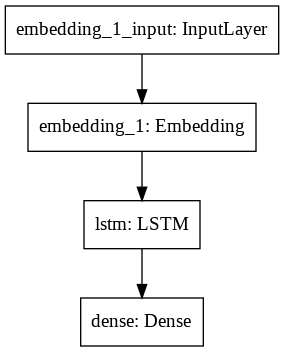

In [137]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [138]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [139]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 23s - loss: 0.5571 - acc: 0.6017
Epoch 2/50
129/129 - 3s - loss: 0.4099 - acc: 0.7137
Epoch 3/50
129/129 - 3s - loss: 0.2951 - acc: 0.7989
Epoch 4/50
129/129 - 3s - loss: 0.2358 - acc: 0.8371
Epoch 5/50
129/129 - 3s - loss: 0.1934 - acc: 0.8657
Epoch 6/50
129/129 - 3s - loss: 0.1257 - acc: 0.9301
Epoch 7/50
129/129 - 3s - loss: 0.0972 - acc: 0.9580
Epoch 8/50
129/129 - 3s - loss: 0.0616 - acc: 0.9726
Epoch 9/50
129/129 - 3s - loss: 0.0473 - acc: 0.9798
Epoch 10/50
129/129 - 3s - loss: 0.0330 - acc: 0.9857
Epoch 11/50
129/129 - 3s - loss: 0.0252 - acc: 0.9908
Epoch 12/50
129/129 - 3s - loss: 0.0245 - acc: 0.9886
Epoch 13/50
129/129 - 3s - loss: 0.0287 - acc: 0.9903
Epoch 14/50
129/129 - 3s - loss: 0.0181 - acc: 0.9932
Epoch 15/50
129/129 - 3s - loss: 0.0182 - acc: 0.9932
Epoch 16/50
129/129 - 3s - loss: 0.0150 - acc: 0.9939
Epoch 17/50
129/129 - 3s - loss: 0.0125 - acc: 0.9951
Epoch 18/50
129/129 - 3s - loss: 0.0100 - acc: 0.9959
Epoch 19/50
129/129 - 3s - loss: 0.0

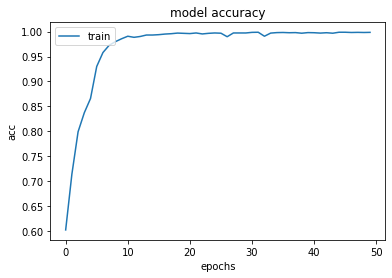

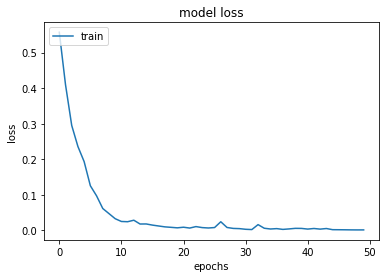

In [140]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('model_loss.png')

In [141]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 2s - loss: 0.0010 - acc: 0.9993
23/23 - 0s - loss: 1.4074 - acc: 0.7098
Train: 0.999, Test: 0.7098


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


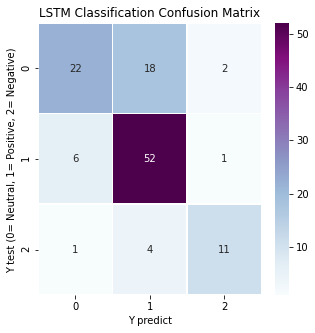

In [149]:
from sklearn.metrics import confusion_matrix
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

rounded_labels=np.argmax(Y_test, axis=1)


lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test (0= Neutral, 1= Positive, 2= Negative) ')
plt.show()

In [147]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 8ms/step - loss: 1.4366 - acc: 0.7265
score: 1.44
acc: 0.73


# Lets test it with different data

In [153]:
message = ['Elon Musk has a responsibility and should not tweet to manipulate crypto market, says CoinDCX CEO']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['Neutral','Positive','Negative']

print(labels[np.argmax(pred)])

Positive
